# SimVP Dataset

> dataset for SimVP

In [1]:
#| default_exp simvp_dataset

In [2]:
#| export
from torch.utils.data import Dataset
import torch
import os
from torchvision import transforms
from maskpredformer.vis_utils import show_video_line

In [3]:
#| export
DEFAULT_DATA_PATH = "/home/enes/dev/maskpredformer/data/DL"

In [22]:
#| export
class DLDataset(Dataset):
    def __init__(self, root, mode, unlabeled=False, pre_seq_len=11, aft_seq_len=11, ep_len=22):
        self.mask_path = os.path.join(root, f"{mode}_masks.pt")
        self.mode = mode
        print("INFO: Loading masks from", self.mask_path)
        if unlabeled:
            self.masks = torch.cat([
                torch.load(self.mask_path), 
                torch.load(os.path.join(root, f"unlabeled_masks.pt")).squeeze()
            ], dim=0)
        else:
            self.masks = torch.load(self.mask_path)
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
        ])
        self.pre_seq_len=pre_seq_len
        self.aft_seq_len=aft_seq_len
        self.seq_per_ep = ep_len - (pre_seq_len + aft_seq_len) + 1

    def __len__(self):
        return self.masks.shape[0] * self.seq_per_ep
    
    def __getitem__(self, idx):
        ep_idx = idx // self.seq_per_ep
        offset = idx % self.seq_per_ep
        total_len = self.pre_seq_len + self.aft_seq_len
        
        if self.mode == "train":
            ep = self.transform(self.masks[ep_idx, offset:offset+total_len])
        else:
            ep = self.masks[ep_idx, offset:offset+total_len]
        data = ep[:self.pre_seq_len].long()
        labels = ep[self.pre_seq_len:].long()
        return data, labels

**Test dataset**

In [23]:
dataset = DLDataset('../data/DL', 'val', pre_seq_len=11, aft_seq_len=3)

INFO: Loading masks from ../data/DL/val_masks.pt


In [24]:
len(dataset)

9000

In [25]:
x, y = dataset[0]

In [26]:
x.shape, y.shape

(torch.Size([11, 160, 240]), torch.Size([3, 160, 240]))

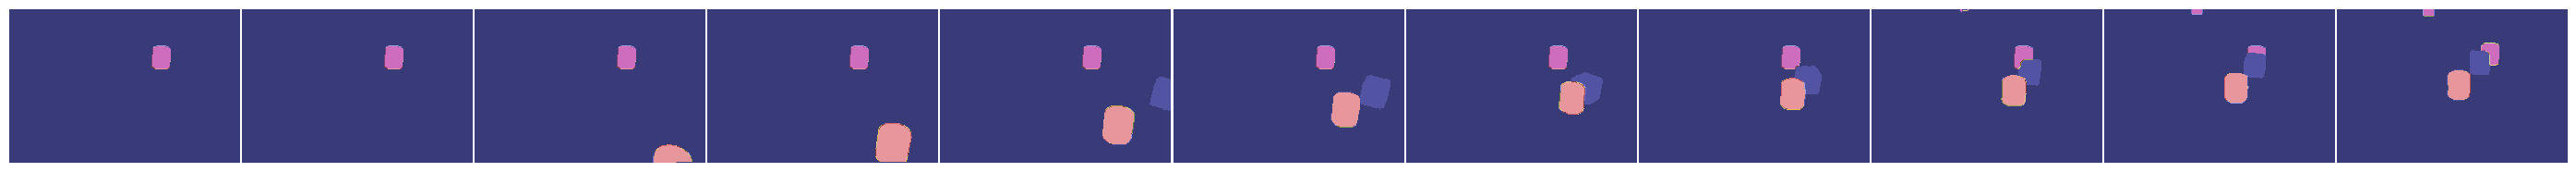

In [27]:
show_video_line(x, len(x))

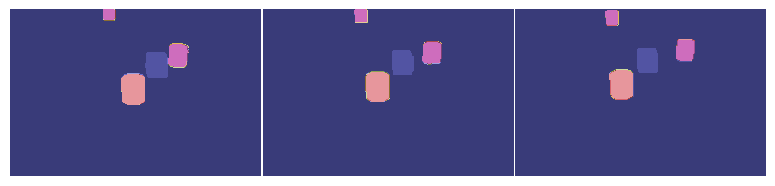

In [28]:
show_video_line(y, len(y))

In [29]:
#| hide
import nbdev; nbdev.nbdev_export()